Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


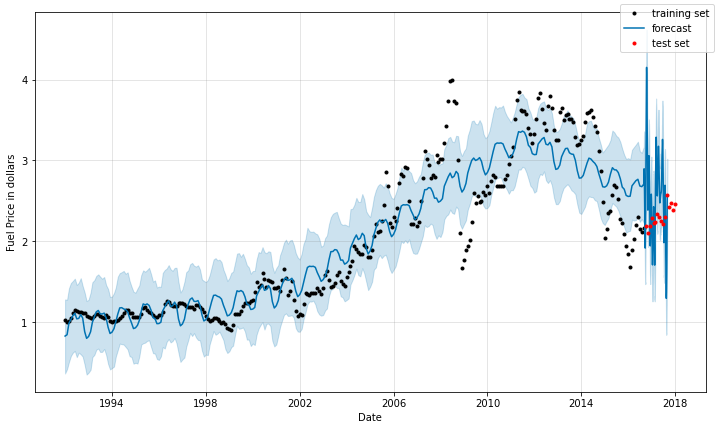

In [1]:
import pandas as pd
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.dates import (
    MonthLocator,
    num2date,
    AutoDateLocator,
    AutoDateFormatter,
    )


def readFile():
    '''
    Method to take excel sheet dataset and parse for time series. Resulting 
    data is put into a pandas dataframe and returned
    '''
    # Read excel data
    energyData = pd.read_excel('forecasting_take_home_data.xlsx',
                            names=['ds', 'y'],
                            skiprows = 11)

    # Make sure excel file was read properly
    if energyData.empty:
        print('Energy data dataframe is empty.')
    else:
        return energyData
    

def splitData(data, trainSetSize):
    '''
    Method to take data and split into train and test sets using scikit learn
    method
    '''
    trainFrame, testFrame = train_test_split(data, test_size = trainSetSize, shuffle = False)

    return trainFrame, testFrame


def createForecastModel(data, modelGrowth):
    '''
    Method to take pandas dataframe data, fit a model to it, and the create a 
    forecast to be returned
    '''
    # train model on given data
    model = Prophet(growth=modelGrowth)
    model.fit(data)

    # create future model to test on test frame
    future = model.make_future_dataframe(365)
    forecast = model.predict(future)

    return model, forecast


def customPlot(model, forecast, testSet, xlabel, ylabel):
    '''
    Custom plot method to take model, forecast, and test data set, and plot on
    one matplotlib figure
    '''
    fig = plt.figure(facecolor='w', figsize=(10,6))
    ax = fig.add_subplot(111)

    fcst_t = forecast['ds'].dt.to_pydatetime()
    ax.plot(model.history['ds'].dt.to_pydatetime(), model.history['y'], 'k.', label='training set')
    ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2', label='forecast')
    
    # plot testing set
    ax.plot(testSet['ds'], testSet['y'], 'r.', label='test set')

    if model.uncertainty_samples:
        ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'],
                        color='#0072B2', alpha=0.2)

    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    fig.legend()

    return fig


def main():

    # read file, split into pandas dataframe accordingly, 
    # and set cap on training set
    energyData = readFile()
    trainFrame, testFrame = splitData(energyData, 0.05)

    # Use training set to create facebook prophet model and forecast
    model, forecast = createForecastModel(trainFrame, 'linear')
    
    # Custom plot model, forecase, and test set to observe accuracy of model
    fig = customPlot(model, forecast, testFrame, 'Date', 'Fuel Price in dollars')


if __name__ == "__main__":
    # execute only if run as a script
    main()
